In the past, we defined the moment of inertia for the bumpy particles in the intuitive way of treating the vertices as if they were point masses.  We would further define the point masses to be uniform, summing up to the total mass of the particle, $m_v N_v = m = 1$.  In this case, we have the moment of inertia for a bumpy particle $I=\Sigma_v^{N_{v}} m_v |r_v - r|^2$ using the particle center of mass $r$.  For the most part, this worked completely fine.  Yet, when pushing the particle geometry to the low friction limit, $I$ could become tiny, on the order of $10^{-5}$.  In the moderate - high friction cases, especially when the number of vertices is large, $I$ approaches that of a ring.  Indeed, that is the geometry of the bumpy particles; however, if we aim to model colloidal particles, we should be more critical.  Colloidal particles (at least 2D slices of them) are not rings.  Ignoring the value of the friction coefficient, the inertia of the particles should be quite comparable to disks.  In the low friction limit, the bumpy particles must approach the disk value $I=\frac{\pi}{2}(\frac{\sigma}{2})^4$.

To address this, we need to first speak about the geometry of the bumpy particles.  The vertices are spaced in even angular increments of $\theta_v=2\pi/N_v$ across a ring of diameter $\sigma_{in}=\sigma-\sigma_v$, such that the outer diameter of the particle, including the vertices, is $\sigma$.  The moment of inertia can be simplified to $I=m (\sigma-\sigma_v)^2$.  When we decrease friction in the current approach, the vertex diameter $\sigma_v$ approaches the particle diameter $\sigma$ which makes the lever arm $\sigma_{in}$ approach $0$, giving a rapidly vanishing $I$.  Concretely, when friction is low, $I$ vanishes; when friction is high, $I$ resembles that of a ring.  Neither of these limits are ideal.  A somewhat overcomplicated solution is to treat the particle as a solid with a uniform mass distribution across the entire excluded area of the particle (traced by a point).  This involves creating a fine polygonal mesh (which we already do when calculating the area) and calculating the moment of inertia for the resulting polygon formed by the mesh exterior.  This is our new approach.

Here, we are showing the results comparing the new approach of calculating $I$ to the old method.

In [1]:
import numpy as np
from pydpmd.utils import split_systems, join_systems
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function, compute_vacf, compute_rotational_msd
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm
from scipy.optimize import minimize
def obj_func(b, x, y, m):
    return np.sum((m * x + b - y) ** 2)

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

In [2]:
root = '/home/mmccraw/dev/data/10-01-25/new-moment-of-inertia/'
dataset = []
file_index = 0
while os.path.exists(file_path := os.path.join(root, f'dynamics_{file_index}')):
    file_index += 1
    try:
        data = load(file_path, location=['final', 'init'], load_trajectory=True, load_full=False)
    except:
        continue
    data.calculate_mu_eff()
    msd_path = os.path.join(file_path, 'msd.npz')
    gmsd, t = compute_rotational_msd(data, msd_path)
    msd = gmsd[:, :, 0]
    amsd = gmsd[:, :, 1]

    pressure = 0.5 * np.mean([data.trajectory[i].stress_tensor_total_x[:, 0] + data.trajectory[i].stress_tensor_total_y[:, 1] for i in range(data.trajectory.num_frames())], axis=0)
    ke_trans = np.add.reduceat(np.mean(0.5 * np.sum(np.array([data.trajectory[i].vel for i in range(data.trajectory.num_frames())]) ** 2, axis=-1) * data.mass[None, :], axis=0), data.system_offset[:-1])
    ke_trans_fluc = np.add.reduceat(np.std(0.5 * np.sum(np.array([data.trajectory[i].vel for i in range(data.trajectory.num_frames())]) ** 2, axis=-1) * data.mass[None, :], axis=0), data.system_offset[:-1])
    ke_rot = np.add.reduceat(np.mean(np.array([data.trajectory[i].angular_vel ** 2 for i in range(data.trajectory.num_frames())]) * data.moment_inertia, axis=0), data.system_offset[:-1])
    ke_rot_fluc = np.add.reduceat(np.std(np.array([data.trajectory[i].angular_vel ** 2 for i in range(data.trajectory.num_frames())]) * data.moment_inertia, axis=0), data.system_offset[:-1])
    ke_total = np.mean([data.trajectory[i].ke_total for i in range(data.trajectory.num_frames())], axis=0)
    pe_total = np.mean([data.trajectory[i].pe_total for i in range(data.trajectory.num_frames())], axis=0)

    keys = np.column_stack((data.mu_eff[data.system_offset[:-1]], data.n_vertices_per_particle[data.system_offset[:-1]]))
    cut = keys.shape[0] // 2
    for i, key in enumerate(keys):
        m = msd[:, i]
        am = amsd[:, i]
        short_time_mask = t < t.min() * 10
        long_time_mask = t > t.max() / 10
        D_T_short = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[short_time_mask]), np.log10(m[short_time_mask]), 2)).x
        D_T_long = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[long_time_mask]), np.log10(m[long_time_mask]), 1)).x
        D_R_short = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[short_time_mask]), np.log10(am[short_time_mask]), 2)).x
        D_R_long = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[long_time_mask]), np.log10(am[long_time_mask]), 1)).x
        dataset.append(
            {
                'mu_eff': key[0],
                'n_vertices': key[1],
                'phi': data.packing_fraction[i],
                'ke_rot': ke_rot[i],
                'ke_rot_fluc': ke_rot_fluc[i],
                'ke_trans': ke_trans[i],
                'ke_trans_fluc': ke_trans_fluc[i],
                'ke_total': ke_total[i],
                'pe_total': pe_total[i],
                'pressure': pressure[i],
                'is_old': i < cut,
                'msd': msd[:, i],
                'amsd': amsd[:, i],
                't': t,
                'D_T_short': D_T_short,
                'D_T_long': D_T_long,
                'D_R_short': D_R_short,
                'D_R_long': D_R_long,
            }
        )

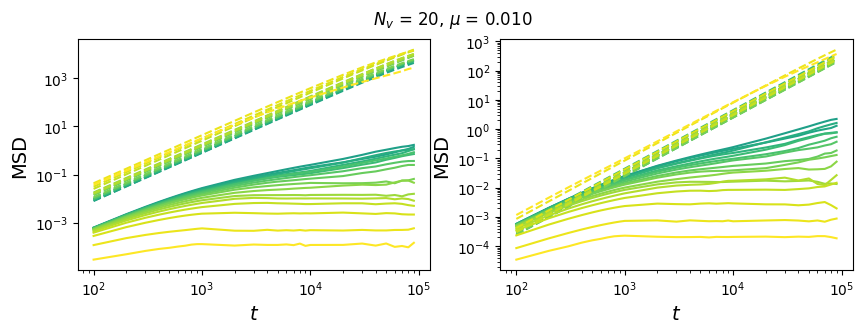

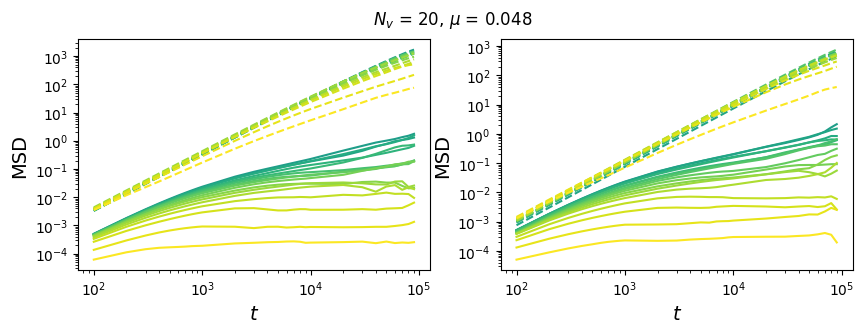

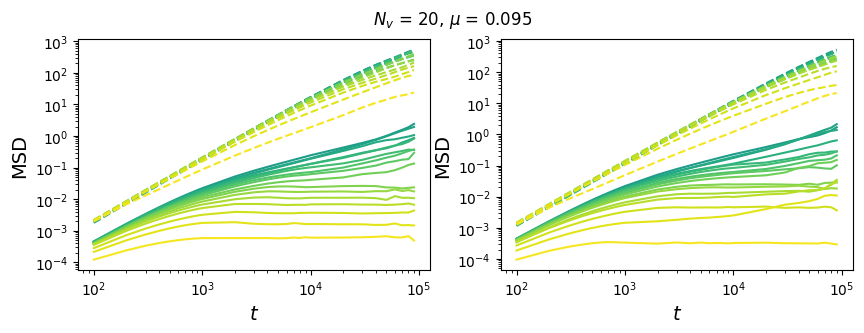

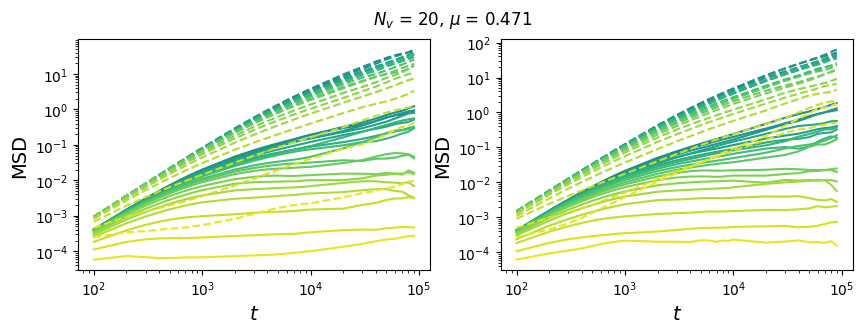

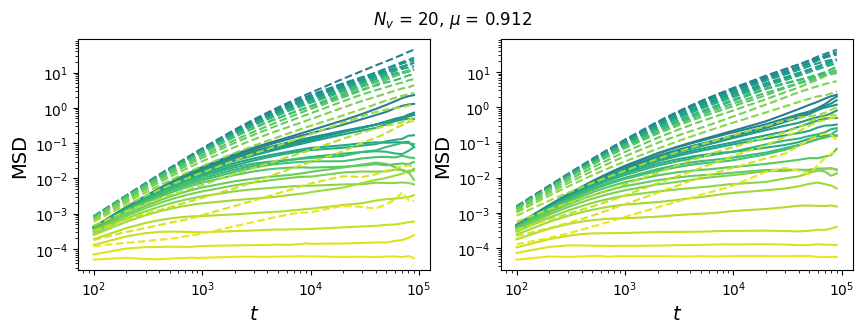

In [12]:
phis = np.unique(np.array([d['phi'] for d in dataset]))
phi_norm = plt.Normalize(min(phis), max(phis))
cmap = plt.cm.viridis

nv = 21
for mu in np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for d in dataset:
        if d['n_vertices'] != nv:
            continue
        if d['mu_eff'] != mu:
            continue
        if d['is_old']:
            a = ax[0]
        else:
            a = ax[1]
        a.plot(d['t'], d['msd'], c=cmap(phi_norm(d['phi'])))
        a.plot(d['t'], d['amsd'], c=cmap(phi_norm(d['phi'])), linestyle='--')
        # fit_mask = d['t'] < d['t'].min() * 10
        # n, log_D = np.polyfit(np.log10(d['t'][fit_mask]), np.log10(d['amsd'][fit_mask]), 1)
        # D = 10 ** log_D
        # a.plot(d['t'], D * d['t'] ** n, c=cmap(phi_norm(d['phi'])), linestyle=':')
        # print(n)
    for a in ax:
        a.set_xscale('log')
        a.set_yscale('log')
        a.set_xlabel(r'$t$', fontsize=14)
        a.set_ylabel(r'MSD', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}, $\mu$ = {mu:.3f}')
    plt.show()

/tmp/ipykernel_3444682/1260893595.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(d['phi'], d['ke_rot_fluc'], c=cmap(phi_norm(d['phi'])), marker='o' if d['is_old'] else 'x')


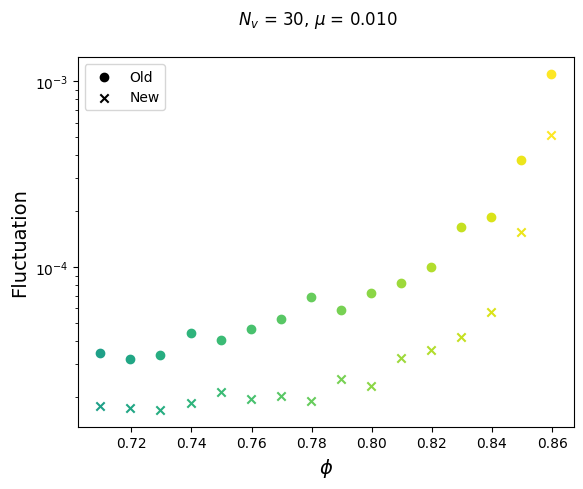

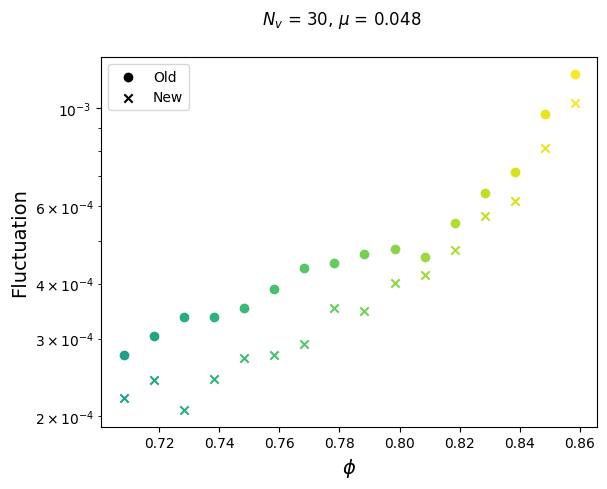

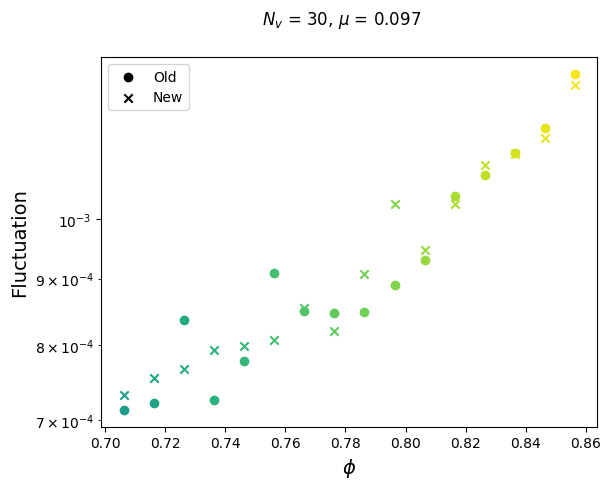

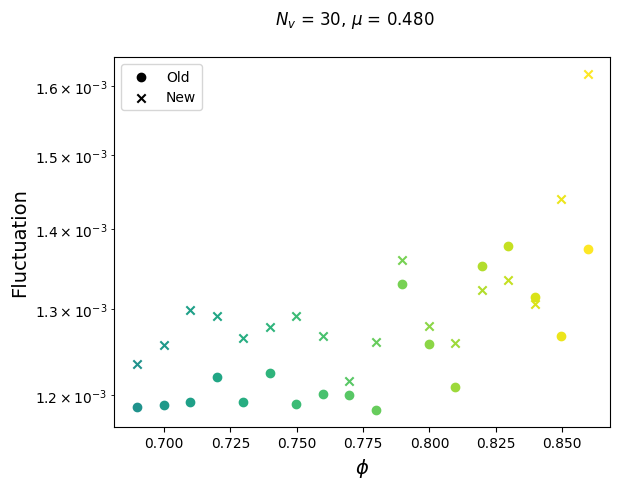

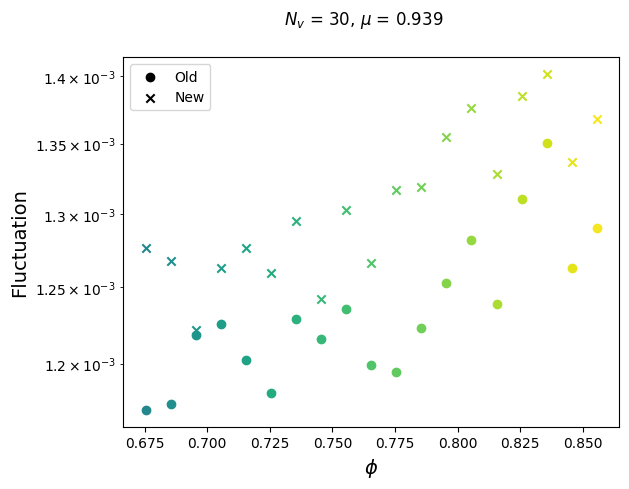

In [13]:
nv = 31
for mu in np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]):
    for d in dataset:
        if d['n_vertices'] != nv:
            continue
        if d['mu_eff'] != mu:
            continue
        plt.scatter(d['phi'], d['ke_rot_fluc'], c=cmap(phi_norm(d['phi'])), marker='o' if d['is_old'] else 'x')
    plt.scatter([], [], c='k', marker='o', label=r'Old')
    plt.scatter([], [], c='k', marker='x', label=r'New')
    plt.ylabel('Fluctuation', fontsize=14)
    plt.xlabel(r'$\phi$', fontsize=14)
    plt.legend()
    plt.yscale('log')
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}, $\mu$ = {mu:.3f}')
    plt.show()

/tmp/ipykernel_3444682/3207087447.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(d['phi'], d['D_T_long'], c=cmap(mu_norm(d['mu_eff'])))
/tmp/ipykernel_3444682/3207087447.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(d['phi'], d['D_T_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
/tmp/ipykernel_3444682/3207087447.py:14: UserWarning: *c* argument looks like a single numeric RGB or R

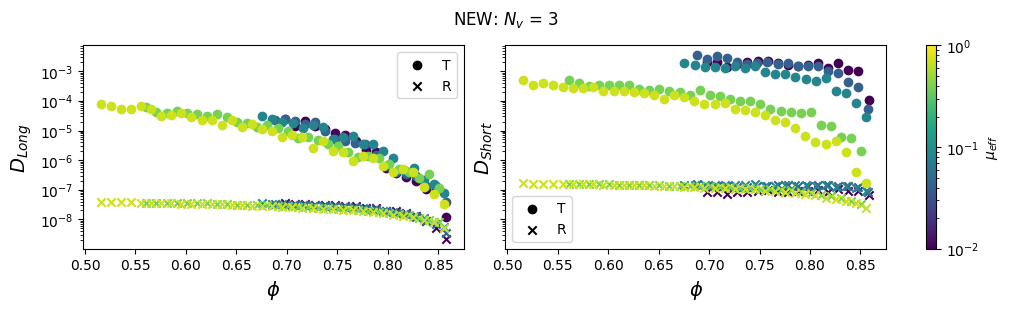

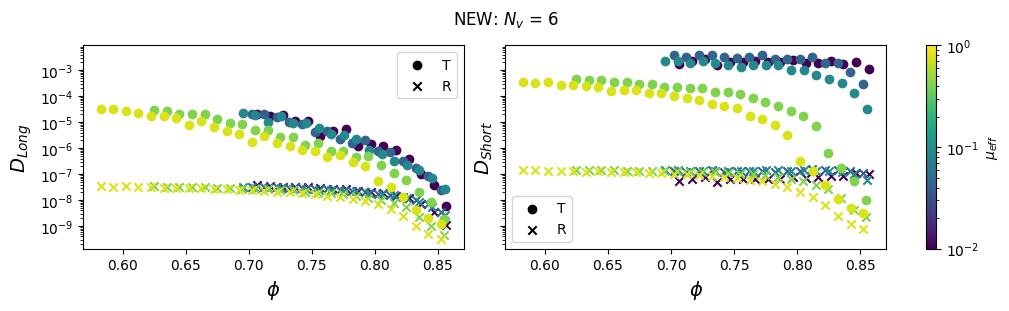

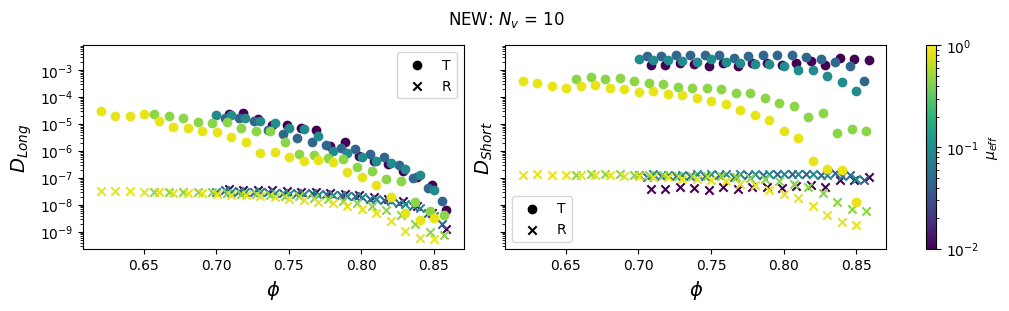

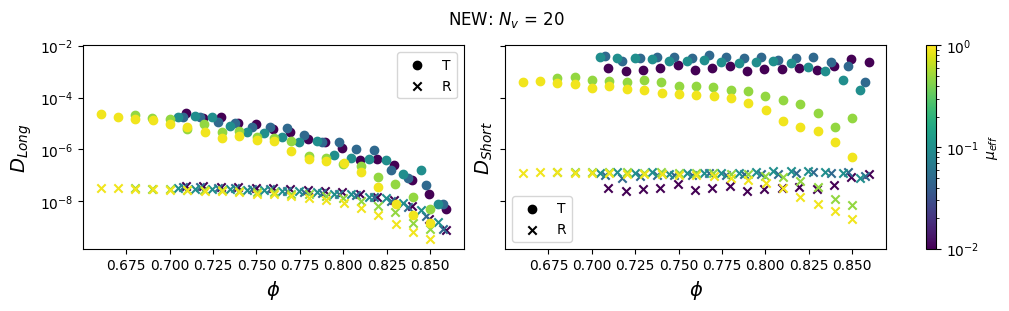

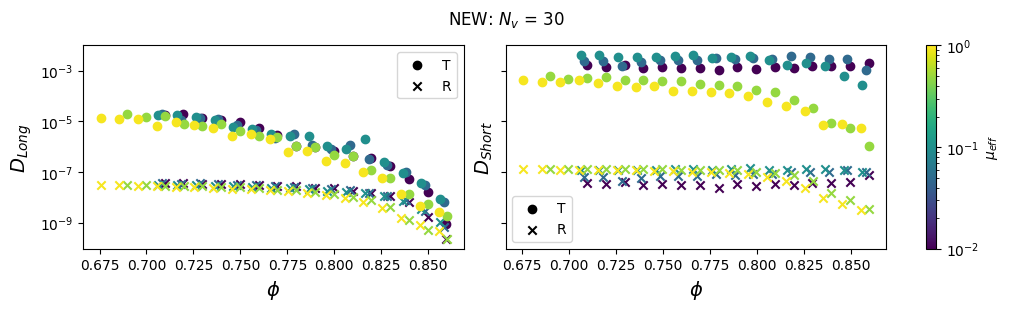

In [ ]:
mu_norm = LogNorm(vmin=1e-2, vmax=1)
for nv in np.unique([d['n_vertices'] for d in dataset]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True, constrained_layout=True)
    for mu in np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]):
        for d in dataset:
            if d['n_vertices'] != nv:
                continue
            if d['mu_eff'] != mu:
                continue
            if d['is_old']:
                continue
            ax[0].scatter(d['phi'], d['D_T_long'], c=cmap(mu_norm(d['mu_eff'])))
            ax[0].scatter(d['phi'], d['D_T_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
            ax[1].scatter(d['phi'], d['D_R_long'], c=cmap(mu_norm(d['mu_eff'])))
            ax[1].scatter(d['phi'], d['D_R_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
    for a in ax:
        a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
        a.scatter([], [], c='k', label=r'T')
        a.scatter([], [], c='k', marker='x', label=r'R')
        a.legend()
    ax[0].set_ylabel(r'$D_{Long}$', fontsize=14)
    ax[1].set_ylabel(r'$D_{Short}$', fontsize=14)
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]))
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.suptitle(fr'NEW: $N_v$ = {int(nv) - 1}')
    plt.show()

/tmp/ipykernel_3444682/1461960965.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(d['phi'], d['D_T_long'], c=cmap(mu_norm(d['mu_eff'])))
/tmp/ipykernel_3444682/1461960965.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(d['phi'], d['D_T_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
/tmp/ipykernel_3444682/1461960965.py:14: UserWarning: *c* argument looks like a single numeric RGB or R

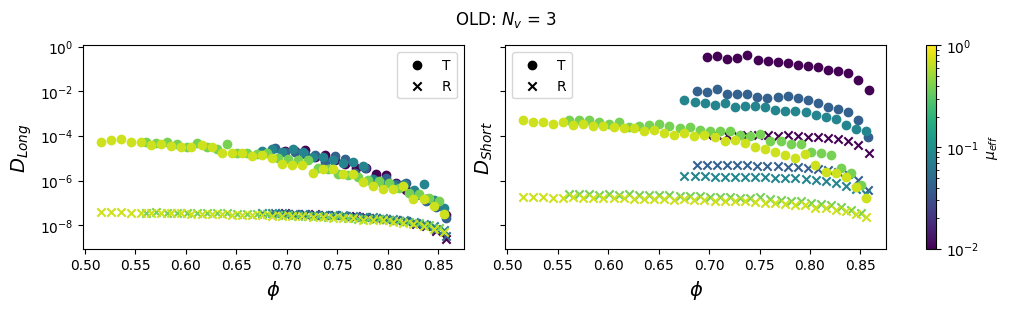

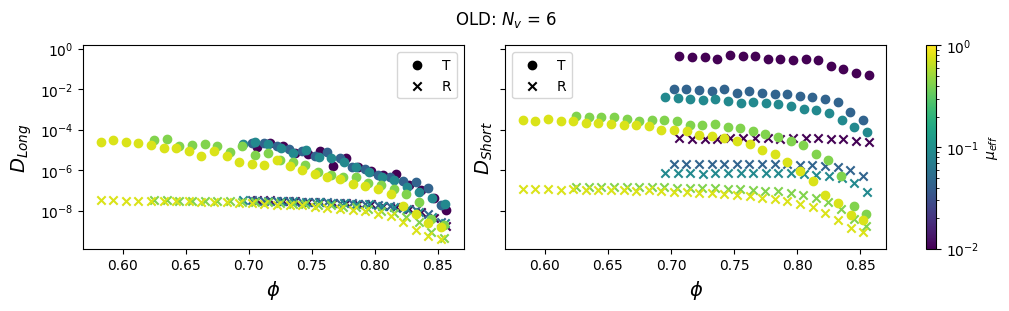

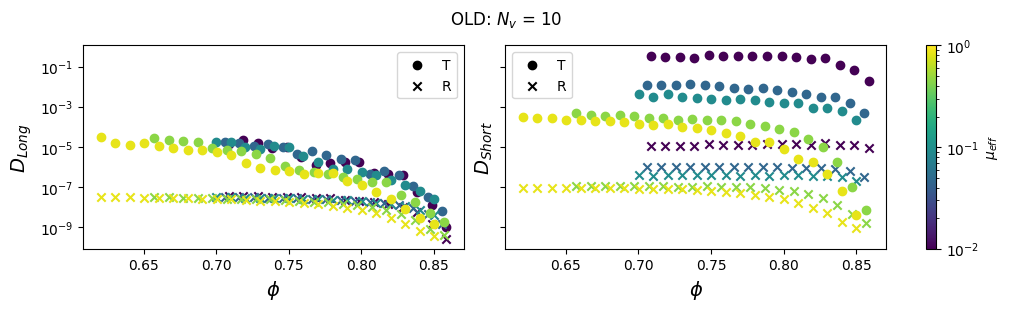

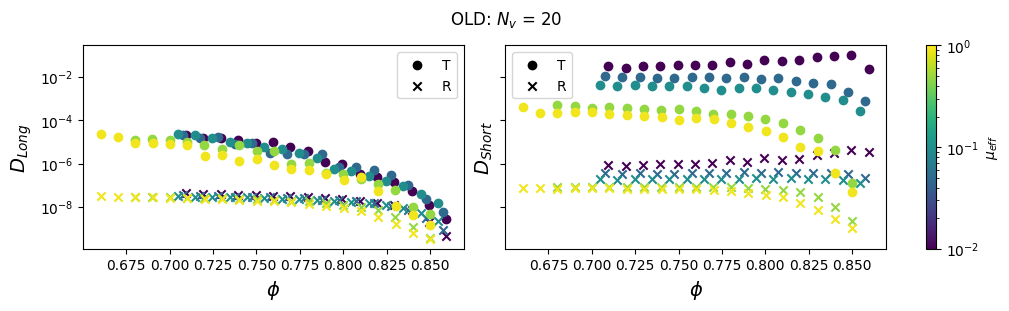

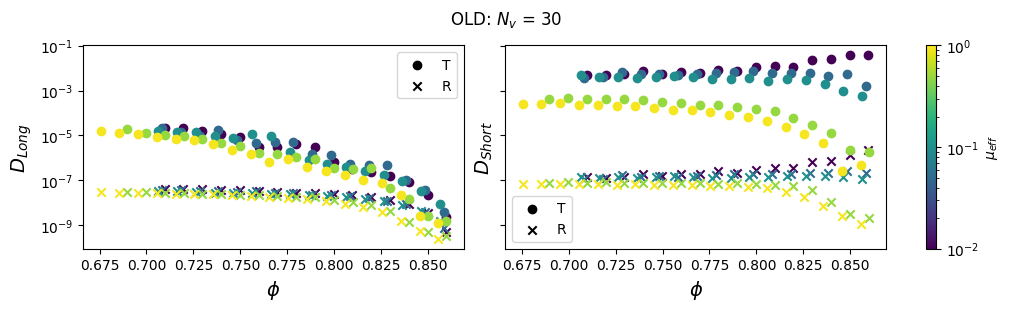

In [10]:
mu_norm = LogNorm(vmin=1e-2, vmax=1)
for nv in np.unique([d['n_vertices'] for d in dataset]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True, constrained_layout=True)
    for mu in np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]):
        for d in dataset:
            if d['n_vertices'] != nv:
                continue
            if d['mu_eff'] != mu:
                continue
            if not d['is_old']:
                continue
            ax[0].scatter(d['phi'], d['D_T_long'], c=cmap(mu_norm(d['mu_eff'])))
            ax[0].scatter(d['phi'], d['D_T_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
            ax[1].scatter(d['phi'], d['D_R_long'], c=cmap(mu_norm(d['mu_eff'])))
            ax[1].scatter(d['phi'], d['D_R_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
    for a in ax:
        a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
        a.scatter([], [], c='k', label=r'T')
        a.scatter([], [], c='k', marker='x', label=r'R')
        a.legend()
    ax[0].set_ylabel(r'$D_{Long}$', fontsize=14)
    ax[1].set_ylabel(r'$D_{Short}$', fontsize=14)
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]))
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.suptitle(fr'OLD: $N_v$ = {int(nv) - 1}')
    plt.show()

These runs are very cursory and don't adequately capture the short and long time behavior of the motion.  In the case of the short time behavior, the motion is ballistic and the particle positions evolve, for a short time $\tau$, as $r(t+\tau)\approx r(t)+v(t) \tau$ where $r$ and $v$ are the generalized positions and velocities of the particles.  This gives the generalized MSD ($\langle \Delta r(\tau)^2 \rangle_{t,N}=\langle |r(t+\tau)-r(t)|^2 \rangle_{t,N}$ (average over time, $t$, and particles, $N$)) as $\langle \Delta r(\tau)^2 \rangle_{t,N}\approx \langle |v(t)|^2 \rangle_{t,N}\ \tau^2$.  By equipartition, we have that $\langle v_{i,k}^2\rangle_t = K T / m_{i,k}$ for degree of freedom $k$ of $d$ for particle $i$.  Thus, $\langle |v(t)|^2 \rangle_{t,N} = \frac{1}{N} \Sigma_i^N \Sigma_k^d \langle v_{i,k}^2 \rangle_{t}=\frac{1}{N} \Sigma_i^N d K T / m_i = d K T / \langle m_i \rangle_N$ (assuming uniform mass within the degrees of freedom for the same particle).  Finally, the short time MSD is: $\langle \Delta r(\tau)^2 \rangle_{t,N}\approx d K T / \langle m_i \rangle_N\ \tau^2$.  If all masses are the same, then we have: $\langle \Delta r(\tau)^2 \rangle_{t,N}\approx \frac{d K T}{m} \tau^2$.  Then, we can see that the short time diffusion is just governed by the ratio of the thermal energy to the 'inertial' energy of the particles, or a measure of the temperature.

When looking short time rotational motion in the lowest friction cases, we can see that there is tremendous run-to-run variability in the short-time rotational behavior.  This is most likely an artifact of randomness in the initialization of the velocities.  Although we scale the velocities to give us a desired average temperature, the distribution of the velocities across the various degrees of freedom is random.  In some cases, we assign more energy to the rotations than in others.  This normally works itself out of the system once everything becomes thermalized; however, in the lowest friction cases, the rotations are not thermalized.  Energy stored in rotations is effectively isolated from the rest of the system.  Whatever distribution of energy we had in these degrees of freedom remains throughout the duration of the run.  Thus, the short time behavior, which really persists for inordinately long times, remains highly varied across initializations (runs).  Another way to see this is to look at the fluctuations in the rotational part of the kinetic energy (several blocks above).  Compared to the old way of calculating the moment of inertia, these fluctuations are tiny in the low friction case.  Again, there is not much energy transfer through these degrees of freedom, as expected.